<a href="https://colab.research.google.com/github/2796gaurav/Hands-OnStockMarketPrediction/blob/main/rnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# install dependencies

!pip install torch
!pip install yfinance

In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import time
import math
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go


In [31]:
#read time series data 
rel_data = yf.Ticker("RELIANCE.NS") 
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,3,19)
data = rel_data.history(start=start, end=end, auto_adjust=True)
data = data.reset_index()
data = data.sort_values('Date')
data = data[['Date','Close']]
data.head()

,Date,Close
0,2021-01-01,1981.126831
1,2021-01-04,1984.466064
2,2021-01-05,1959.795410
3,2021-01-06,1908.111694
4,2021-01-07,1905.021729


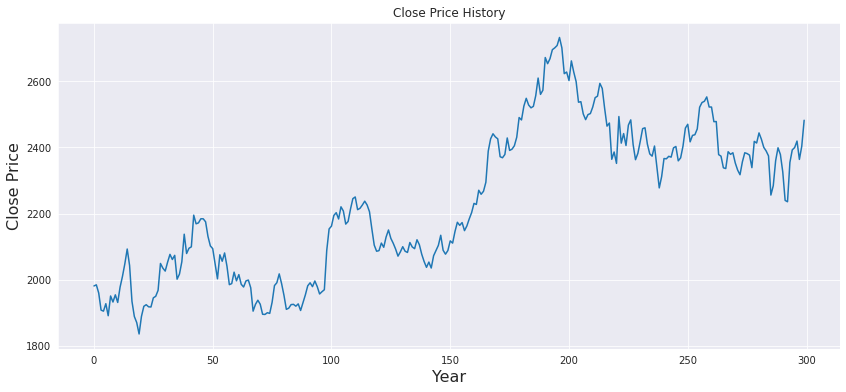

In [32]:
# plot the chart
plt.figure(figsize=(14,6))
plt.title('Close Price History')
plt.plot(data['Close'])

plt.xlabel('Year', fontsize=16)
plt.ylabel('Close Price' , fontsize=16)
plt.show()

In [33]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(-1, 1))
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
data.head()

,Date,Close
0,2021-01-01,-0.676084
1,2021-01-04,-0.668628
2,2021-01-05,-0.723709
3,2021-01-06,-0.839099
4,2021-01-07,-0.845998


In [34]:
data = data[['Close']] # select only close column

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    test_set_size = 50
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]





lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(data, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (230, 19, 1)
y_train.shape =  (230, 1)
x_test.shape =  (50, 19, 1)
y_test.shape =  (50, 1)


In [35]:
# x_train

In [36]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [37]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_layers, output_dim):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Forward propagation by passing in the input and hidden state into the model
        out, (hn, cn) = self.rnn(x, (h0.detach()))
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = self.fc(out[:, -1, :]) 
        # Convert the final state to our desired output shape (batch_size, output_dim)
        return out

In [40]:
model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [41]:
model

RNNModel(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [42]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4346454441547394
Epoch  1 MSE:  0.22069665789604187
Epoch  2 MSE:  0.180490642786026
Epoch  3 MSE:  0.1020703911781311
Epoch  4 MSE:  0.06036002188920975
Epoch  5 MSE:  0.029936719685792923
Epoch  6 MSE:  0.0576648972928524
Epoch  7 MSE:  0.009666974656283855
Epoch  8 MSE:  0.030704842880368233
Epoch  9 MSE:  0.03587204962968826
Epoch  10 MSE:  0.025060027837753296
Epoch  11 MSE:  0.0174525436013937
Epoch  12 MSE:  0.016185473650693893
Epoch  13 MSE:  0.014387429691851139
Epoch  14 MSE:  0.01662631332874298
Epoch  15 MSE:  0.019424816593527794
Epoch  16 MSE:  0.014099557884037495
Epoch  17 MSE:  0.008866052143275738
Epoch  18 MSE:  0.010221860371530056
Epoch  19 MSE:  0.01434409897774458
Epoch  20 MSE:  0.015048669651150703
Epoch  21 MSE:  0.011867271736264229
Epoch  22 MSE:  0.008744719438254833
Epoch  23 MSE:  0.008267015218734741
Epoch  24 MSE:  0.009571160189807415
Epoch  25 MSE:  0.010509837418794632
Epoch  26 MSE:  0.010175643488764763
Epoch  27 MSE:  0.008971846

In [43]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

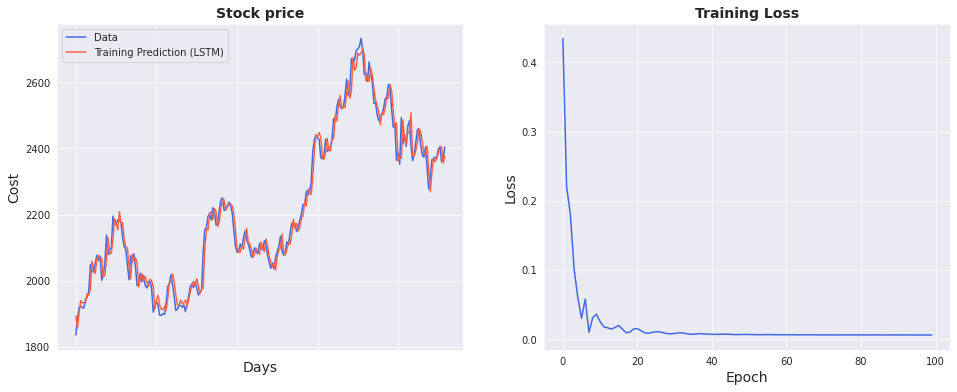

In [44]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [45]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 34.07 RMSE
Test Score: 44.80 RMSE
